In [1]:
# can be used to find nearby yelpers and target them with deal and specials, information can be sold to businesses

# win for business, yelp, and yelper

# EDA

<b>Objective:</b> To explore the Yelp datasets to derive insights from the data.

<b>Some initial questions:</b>
* Which businesses are getting top reviews?
* Which categories of business are getting top reviews?
* How businesses are getting reviewed over time.
<br>
* Are the categories of tending businesses different from top reviewed businesses?
* Which categories of businesses are new?
* Which categories of businesses are getting bad reviews?
<br>
* What are most common words in positive reviews?
* What are most common words in bad reviews?

<b>Terminology used:</b>

* Top reviewed business : Business with most numbers of positive reviews
* Negatively reviewed business : Business with most numbers of negative reviews
* Trending business : Business with most number of reviews, with more than 4 stars in recent years
* Positive review : Review > 3 stars
* Neutral review: Review = 3 stars
* Negative review : Review < 3 stars

In [ ]:
# import databricks.koalas as ks
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import time
import json
import os
import pickle
from collections import Counter

import pandas_profiling
# df.profile_report(style={'full_width':True})
# df.profile_report(title='Pandas Profiling Report')

import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')
font = {'size':16}
import seaborn as sns

import scipy.stats as scs

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



## Load data into memory

In [3]:
master_df = pd.read_pickle('../data/master_df.pkl')
print(master_df.shape)
master_df.head(2)

(4201684, 31)


,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_x,review_count_x,is_open,attributes,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date,name_y,review_count_y,yelping_since,friends,fans,average_stars,likes,compliments,elite_years
0,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","[Specialty Food, Restaurants, Dim Sum, Importe...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",6W0MQHmasK0IsaoDo4bmkw,2K62MJ4CJ19L8Tp5pRfjfQ,3.0,3,2,0,My girlfriend and I went for dinner at Emerald...,2017-01-27 21:54:30,David,57,2014-11-27 22:36:00,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",1,3.3,100,16,2
1,NX1281ugzs2navHAX5X9cQ,Cha Me Cha,"8333 Kennedy Road, Suite 1078",Markham,ON,L3R 1J5,43.856327,-79.303884,3.0,293,1,"{'OutdoorSeating': 'False', 'RestaurantsPriceR...","[Bubble Tea, Food, Restaurants, Taiwanese, Cof...","{'Monday': '12:0-0:0', 'Tuesday': '12:0-0:0', ...",wbRQarYt_jBHNleOr0e1ng,2K62MJ4CJ19L8Tp5pRfjfQ,4.0,1,0,0,We decided to make a stop at Cha Me Cha for a ...,2018-08-20 21:38:43,David,57,2014-11-27 22:36:00,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",1,3.3,100,16,2


# Exploring the data

### Looking at businesses with highest number of reviews

In [4]:
business_review_count = master_df.groupby(['state', 'city', 'name_x', 'business_id'])['review_id'].count().sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').to_frame()
business_review_count = business_review_count.reset_index()
business_review_count.head(10)

,state,city,name_x,business_id,review_id
0,NV,Las Vegas,Mon Ami Gabi,4JNXUYY8wbaaDmk3BPzlWw,8570
1,NV,Las Vegas,Bacchanal Buffet,RESDUcs7fIiihp38-d6_6g,8568
2,NV,Las Vegas,Wicked Spoon,K7lWdNUhCbcnEvI0NhGewg,6887
3,NV,Las Vegas,Hash House A Go Go,f4x1YBxkLrZg652xt2KR5g,5847
4,NV,Las Vegas,Gordon Ramsay BurGR,cYwJA2A6I12KNkm2rtXd5g,5575
5,NV,Las Vegas,Earl of Sandwich,DkYS3arLOhA8si5uUEmHOw,5206
6,NV,Las Vegas,The Buffet,2weQS-RnoOBhb1KsHKyoSQ,4534
7,NV,Las Vegas,The Cosmopolitan of Las Vegas,5LNZ67Yw9RD6nf4_UhXOjw,4522
8,NV,Las Vegas,Secret Pizza,iCQpiavjjPzJ5_3gPD5Ebg,4351
9,NV,Las Vegas,The Buffet at Bellagio,ujHiaprwCQ5ewziu0Vi9rw,4318


### Remove 'Hotels'

it looks like there are hotels mixed in with the reviews, let's remove the businesses with 'hotel' in the category most of them are not restaurants yet are highly reviewed

In [5]:
# look at businesses with 'Hotels' in categories

master_df['hotel?'] = master_df['categories'].apply(lambda x: 1 if 'Hotels' in x else 0)
master_df[master_df['hotel?'] == 1].shape

(89929, 32)

### removing 282 'Hotels'

In [6]:
# Remove 'Hotels' from df

master_df = master_df[master_df['hotel?'] == 0]

### Cities with largest number of reviews

In [7]:
master_df.city.value_counts()[:10]

Las Vegas     1170187
Phoenix        423236
Toronto        375061
Scottsdale     227026
Charlotte      207969
Pittsburgh     161459
Tempe          117125
Montréal       116637
Henderson      110403
Mesa            89428
Name: city, dtype: int64

In [8]:
import chart_studio.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import plotly.graph_objects as go

import pandas as pd
import plotly.graph_objects as go

import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_ebola.csv')
df.head()

colors = ['rgb(239,243,255)','rgb(189,215,231)','rgb(107,174,214)','rgb(33,113,181)']
months = {6:'June',7:'July',8:'Aug',9:'Sept'}

fig = go.Figure()

for i in range(6,10)[::-1]:
    df_month = df.query('Month == %d' %i)
    fig.add_trace(go.Scattergeo(
            lon = df_month['Lon'],
            lat = df_month['Lat'],
            text = df_month['Value'],
            name = months[i],
            marker = dict(
                size = df_month['Value']/50,
                color = colors[i-6],
                line_width = 0
            )))

df_sept = df.query('Month == 9')
fig['data'][0].update(mode='markers+text', textposition='bottom center',
                      text=df_sept['Value'].map('{:.0f}'.format).astype(str)+' '+\
                      df_sept['Country'])

# Inset
fig.add_trace(go.Choropleth(
        locationmode = 'country names',
        locations = df_sept['Country'],
        z = df_sept['Value'],
        text = df_sept['Country'],
        colorscale = [[0,'rgb(0, 0, 0)'],[1,'rgb(0, 0, 0)']],
        autocolorscale = False,
        showscale = False,
        geo = 'geo2'
    ))
fig.add_trace(go.Scattergeo(
        lon = [21.0936],
        lat = [7.1881],
        text = ['Africa'],
        mode = 'text',
        showlegend = False,
        geo = 'geo2'
    ))

fig.update_layout(
    title = go.layout.Title(
        text = 'Ebola cases reported by month in West Africa 2014<br> \
Source: <a href="https://data.hdx.rwlabs.org/dataset/rowca-ebola-cases">\
HDX</a>'),
    geo = go.layout.Geo(
        resolution = 50,
        scope = 'africa',
        showframe = False,
        showcoastlines = True,
        landcolor = "rgb(229, 229, 229)",
        countrycolor = "white" ,
        coastlinecolor = "white",
        projection_type = 'mercator',
        lonaxis_range= [ -15.0, -5.0 ],
        lataxis_range= [ 0.0, 12.0 ],
        domain = dict(x = [ 0, 1 ], y = [ 0, 1 ])
    ),
    geo2 = go.layout.Geo(
        scope = 'africa',
        showframe = False,
        landcolor = "rgb(229, 229, 229)",
        showcountries = False,
        domain = dict(x = [ 0, 0.6 ], y = [ 0, 0.6 ]),
        bgcolor = 'rgba(255, 255, 255, 0.0)',
    ),
    legend_traceorder = 'reversed'
)

fig.show()

,Country,Month,Year,Lat,Lon,Value
0,Guinea,3,14,9.95,-9.7,122.0
1,Guinea,4,14,9.95,-9.7,224.0
2,Guinea,5,14,9.95,-9.7,291.0
3,Guinea,6,14,9.95,-9.7,413.0
4,Guinea,7,14,9.95,-9.7,460.0


Scattergeo({
    'lat': array([ 9.95,  6.43, 14.5 ,  8.46]),
    'lon': array([ -9.7 ,  -9.43, -14.45, -11.78]),
    'marker': {'color': 'rgb(33,113,181)',
               'line': {'width': 0},
               'size': array([2.044e+01, 6.724e+01, 6.000e-02, 3.880e+01])},
    'mode': 'markers+text',
    'name': 'Sept',
    'text': array(['1022 Guinea', '3362 Liberia', '3 Senegal', '1940 Sierra Leone'],
                  dtype=object),
    'textposition': 'bottom center'
})

### Count of (<font color = 'green'>Positive</font> / <font color = 'tan'>Neutral</font> / <font color = 'red'>Negative</font>) Reviews by City

In [9]:
master_df['positive_review'] = master_df['stars_x'] > 3
master_df['neutral_review'] = master_df['stars_x'] == 3
master_df['negative_review'] = master_df['stars_x'] < 3

review_by_statecity = master_df.groupby(['state', 'city'])['review_id', 'positive_review', 'neutral_review', 'negative_review'].sum().astype('int')
review_by_statecity['review_count'] = review_by_statecity['positive_review'] + review_by_statecity['neutral_review'] + review_by_statecity['negative_review']
review_by_statecity['positive_ratio'] = review_by_statecity['positive_review'] / review_by_statecity['review_count']
review_by_statecity['positive_ratio'] = review_by_statecity['positive_ratio'].map('{:,.2f}'.format)
review_by_statecity.sort_values(by='review_count', axis=0, ascending=False, inplace=True)
review_by_statecity.reset_index(inplace=True)

In [10]:
review_by_statecity.sort_values(by='review_count', axis=0, ascending=False, inplace=True)
review_by_statecity.head(10)

,state,city,positive_review,neutral_review,negative_review,review_count,positive_ratio
0,NV,Las Vegas,989528,118729,61930,1170187,0.85
1,AZ,Phoenix,361686,37247,24303,423236,0.85
2,ON,Toronto,288501,61571,24980,375052,0.77
3,AZ,Scottsdale,201330,18897,6799,227026,0.89
4,NC,Charlotte,166510,25275,16184,207969,0.80
5,PA,Pittsburgh,134199,18742,8518,161459,0.83
6,AZ,Tempe,94266,15081,7778,117125,0.80
7,QC,Montréal,102816,8446,5375,116637,0.88
8,NV,Henderson,90952,11240,8211,110403,0.82
9,AZ,Mesa,69549,11541,8338,89428,0.78


In [11]:
vegas_reviews = master_df.groupby(['state', 'city', 'name_x', 'business_id'])['review_id'].count().sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').to_frame()
vegas_reviews = vegas_reviews.reset_index()
vegas_reviews = vegas_reviews[vegas_reviews['state'] == 'NV']
vegas_reviews = vegas_reviews[vegas_reviews['city'] == 'Las Vegas']
vegas_reviews.head(10)

,state,city,name_x,business_id,review_id
0,NV,Las Vegas,Mon Ami Gabi,4JNXUYY8wbaaDmk3BPzlWw,8570
1,NV,Las Vegas,Bacchanal Buffet,RESDUcs7fIiihp38-d6_6g,8568
2,NV,Las Vegas,Wicked Spoon,K7lWdNUhCbcnEvI0NhGewg,6887
3,NV,Las Vegas,Hash House A Go Go,f4x1YBxkLrZg652xt2KR5g,5847
4,NV,Las Vegas,Gordon Ramsay BurGR,cYwJA2A6I12KNkm2rtXd5g,5575
5,NV,Las Vegas,Earl of Sandwich,DkYS3arLOhA8si5uUEmHOw,5206
6,NV,Las Vegas,Secret Pizza,iCQpiavjjPzJ5_3gPD5Ebg,4351
7,NV,Las Vegas,The Buffet at Bellagio,ujHiaprwCQ5ewziu0Vi9rw,4318
8,NV,Las Vegas,Lotus of Siam,KskYqH1Bi7Z_61pH6Om8pg,4131
9,NV,Las Vegas,Bouchon,rcaPajgKOJC2vo_l3xa42A,4014


## Planning

to build a recommender we can use the explicit feedback features from the dataset: star ratings

## Base Model for Montreal, QC Canada

* I wanted to pick a city with <5000 reviews so the model could be quickly computed
* I also wanted a city with a recognizable name so I could better understand any data anomolies if they appear (e.g. certain outlier businesses like chains that are unexpected or skew the data)

In [13]:
montreal_reviews = review_by_statecity[review_by_statecity['state'] == 'QC']
montreal_reviews = montreal_reviews[montreal_reviews['city'] == 'Montreal']
montreal_reviews

,state,city,positive_review,neutral_review,negative_review,review_count,positive_ratio
65,QC,Montreal,2325,536,72,2933,0.79


### Create Montreal Dataset

In [14]:
montreal_df = master_df[master_df['state'] == 'QC']
montreal_df = montreal_df[montreal_df['city'] == 'Montreal']
montreal_df = montreal_df.reset_index(drop=True)
montreal_df.head()

,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_x,review_count_x,is_open,attributes,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date,name_y,review_count_y,yelping_since,friends,fans,average_stars,likes,compliments,elite_years,hotel?,positive_review,neutral_review,negative_review
0,JgKpVoemZ-Khkfgif5V7qQ,The Bier Markt,"1221, Boul Réné-Levesque Ouest",Montreal,QC,H3G 1T1,45.497315,-73.571964,3.5,191,1,"{'BikeParking': 'True', 'RestaurantsReservatio...","[Bars, Beer, Wine & Spirits, Restaurants, Venu...","{'Monday': '11:30-0:0', 'Tuesday': '11:30-0:0'...",swK_XHW-66bfISIK7uJP9A,aIqDek9d1fDEgLIAWXMGSA,4.0,0,0,0,Acrually my meal was very average. I would hav...,2018-03-27 23:08:23,Robert,325,2013-03-06 21:34:05,"7vCCPqR9cJoy_AY0BkdyUg, k-vY4c--WIGWMzDezi3xAA...",8,3.92,586,86,1,0,True,False,False
1,lcTa0q9Wo4wNyLCIgWFRUA,La Société Montréal,1415 Rue de la Montagne,Montreal,QC,H3G 1Z3,45.498296,-73.575551,4.0,79,1,"{'Alcohol': 'u'full_bar'', 'BusinessParking': ...","[Restaurants, Breakfast & Brunch, French]","{'Monday': '7:0-0:0', 'Tuesday': '7:0-0:0', 'W...",W89PPgDhz-ZK6iyhF_Dssw,BF7rMYMH6OvJOBIQhsnQvg,4.0,1,0,0,"""A true brasserie....relexed setting great sea...",2016-01-05 02:50:12,Tony,222,2010-01-23 18:47:26,"31g2g1CcwnAa-84pPQowlw, XpJVDTgMze3FaEFi0bCMHw...",8,3.66,467,18,3,0,True,False,False
2,dXwDDsQv3tMzw69pqmD-Vw,Cacao 70,"3485, Avenue Du Parc",Montreal,QC,H2X 2H6,45.509533,-73.573006,3.5,81,1,"{'RestaurantsPriceRange2': '2', 'Ambience': '{...","[Specialty Food, Food, Restaurants, Breakfast ...","{'Monday': '10:0-23:0', 'Tuesday': '10:0-23:0'...",BLmwrmeM1cPVrvha26HQCg,fENhF1F6I9c2ssnkfprYzw,4.0,1,1,0,It has become a Montreal tradition to eat here...,2016-09-16 03:53:48,Noor,55,2014-07-18 06:16:59,"s1HoddKof1iQRZzjbyOiIw, Qt_nFB_UXWvEEWACrLdKFw...",13,3.98,155,50,2,0,True,False,False
3,kpuMEGNsjD4R5VnJa8IWTw,Dunn's Famous,1249 Rue Metcalfe,Montreal,QC,H3B 2V5,45.500557,-73.571625,4.0,205,1,"{'RestaurantsDelivery': 'False', 'RestaurantsR...","[Burgers, Delis, Restaurants, Poutineries, San...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",Znxo1dRam3HjbSMwbL-rLw,XjyneOR2t_o12hSt-MncKQ,5.0,0,0,0,I don't know if words can really explain my lo...,2015-12-19 15:24:25,Mark,214,2012-02-21 18:56:34,"j7xYaFA7CNmL9SGV5qeTUw, HVRCuxmrWN1Hu7bJVoOMxg...",1,3.63,325,11,1,0,True,False,False
4,7fHPkHUO_tcjUUWJqP_aKw,La Chronique,104 Avenue Laurier Ouest,Montreal,QC,H2T 2N7,45.521455,-73.593749,4.5,30,1,"{'BikeParking': 'True', 'RestaurantsTakeOut': ...","[Restaurants, French]","{'Tuesday': '18:0-22:0', 'Wednesday': '18:0-22...",0Y4TwIUsZ4BSXpwvYBtOuA,U4INQZOPSUaj8hMjLlZ3KA,3.0,9,0,2,The Why: Recommended by a Montreal contact wh...,2012-09-08 14:50:27,Michael,4308,2008-01-31 02:55:30,"yqumc_CYlWeghZ5vM3Ilyw, mX84lBw8jwS2uQqdgKu_aA...",912,3.88,49215,4485,7,0,True,False,False


### Review Montreal DF

In [15]:
montreal_df.describe()

,latitude,longitude,stars_x,review_count_x,is_open,stars_y,useful,funny,cool,review_count_y,fans,average_stars,likes,compliments,elite_years,hotel?
count,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.0
mean,45.505443,-73.573012,3.693658,143.088646,0.941698,3.659734,0.909308,0.301057,0.466417,143.431640,13.052506,3.761742,854.009206,183.244460,2.010569,0.0
std,0.015366,0.017785,0.520881,98.552769,0.234354,1.208826,1.904783,1.128988,1.414207,330.796597,58.847816,0.632059,6141.882333,1533.150188,1.951201,0.0
min,45.432283,-73.752866,1.500000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.0
25%,45.497488,-73.579752,3.500000,58.000000,1.000000,3.000000,0.000000,0.000000,0.000000,11.000000,0.000000,3.500000,9.000000,0.000000,1.000000,0.0
50%,45.502654,-73.571964,3.500000,105.000000,1.000000,4.000000,0.000000,0.000000,0.000000,44.000000,1.000000,3.820000,59.000000,4.000000,1.000000,0.0
75%,45.509533,-73.560258,4.000000,257.000000,1.000000,5.000000,1.000000,0.000000,1.000000,143.000000,8.000000,4.110000,331.000000,37.000000,2.000000,0.0
max,45.585827,-73.541961,5.000000,281.000000,1.000000,5.000000,35.000000,25.000000,31.000000,10022.000000,1010.000000,5.000000,185997.000000,38497.000000,13.000000,0.0


In [16]:
montreal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2933 entries, 0 to 2932
Data columns (total 35 columns):
business_id        2933 non-null object
name_x             2933 non-null object
address            2933 non-null object
city               2933 non-null object
state              2933 non-null object
postal_code        2933 non-null object
latitude           2933 non-null float64
longitude          2933 non-null float64
stars_x            2933 non-null float64
review_count_x     2933 non-null int64
is_open            2933 non-null int64
attributes         2914 non-null object
categories         2933 non-null object
hours              2772 non-null object
review_id          2933 non-null object
user_id            2933 non-null object
stars_y            2933 non-null float64
useful             2933 non-null int64
funny              2933 non-null int64
cool               2933 non-null int64
text               2933 non-null object
date               2933 non-null object
name_y        

### Montreal EDA

#### Restaurant ratings

montreal mean rating: 3.66
montreal medium rating: 4.00
montreal std of rating: 1.21


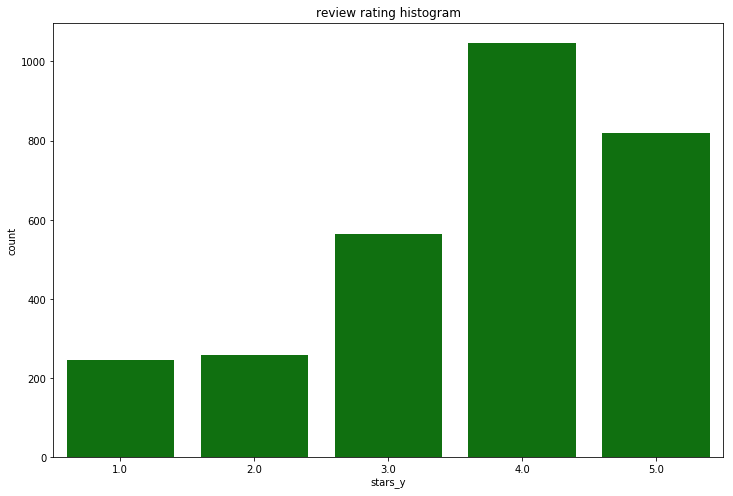

In [70]:
fig, ax = plt.subplots(1, figsize = (12, 8))
a = sns.countplot(montreal_df['stars_y'], color='green')
a = ax.set_title('review rating histogram')

print('montreal mean rating: {:.2f}'.format(montreal_df['stars_y'].mean()))
print('montreal medium rating: {:.2f}'.format(montreal_df['stars_y'].median()))
print('montreal std of rating: {:.2f}'.format((montreal_df['stars_y'].std())))

min: 1
max: 8


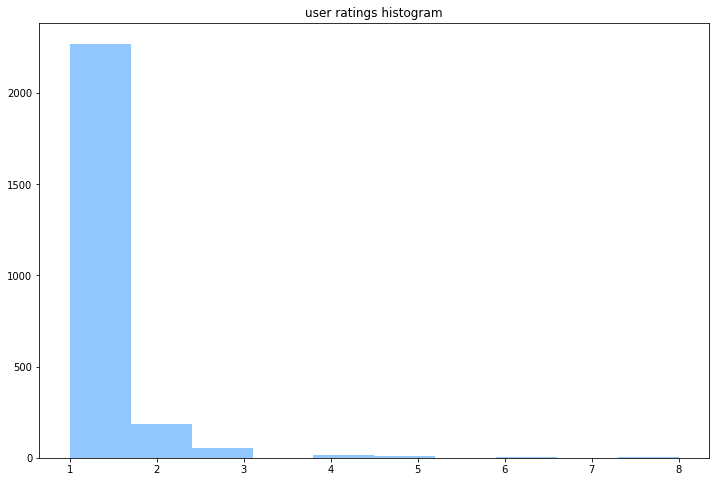

In [25]:
user_rating_count = montreal_df.groupby('user_id').count()

fig, ax = plt.subplots(1, figsize = (12, 8))
a = ax.hist(user_rating_count['business_id'])
a = ax.set_title('user ratings histogram')

print('min: {}'.format(min(user_rating_count['business_id'])))
print('max: {}'.format(max(user_rating_count['business_id'])))

min: 3
max: 284


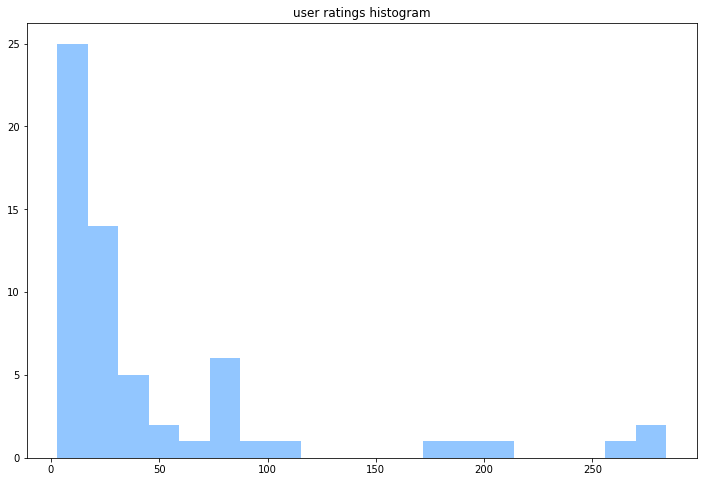

In [32]:
restaurant_rating_count = montreal_df.groupby('business_id').count()

fig, ax = plt.subplots(1, figsize = (12, 8))
a = ax.hist(restaurant_rating_count['user_id'], bins=20)
a = ax.set_title('user ratings histogram')

print('min: {}'.format(min(restaurant_rating_count['user_id'])))
print('max: {}'.format(max(restaurant_rating_count['user_id'])))

In [43]:
rated_items = sum(restaurant_rating_count['user_id'])
print(rated_items)
num_items = len(restaurant_rating_count['user_id'])
print(num_items)
num_users = len(user_rating_count['business_id'])
print(num_users)

print('\nThe density of our data is {:.5f}'.format(rated_items/(num_items*num_users)))

2933
61
2535

The density of our data is 0.01897


In [46]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

# Load the movielens-100k dataset (download it if needed).
data = Dataset.load_builtin('ml-100k')

# Use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9350  0.9367  0.9349  0.9285  0.9435  0.9357  0.0048  
MAE (testset)     0.7380  0.7374  0.7361  0.7323  0.7431  0.7374  0.0035  
Fit time          5.00    4.98    5.06    5.27    5.22    5.11    0.12    
Test time         0.15    0.15    0.29    0.16    0.16    0.18    0.05    


{'test_rmse': array([0.93497275, 0.93673917, 0.93486954, 0.9285469 , 0.94352859]),
 'test_mae': array([0.73804529, 0.73738675, 0.7361012 , 0.73230959, 0.74313962]),
 'fit_time': (5.003489017486572,
  4.9849700927734375,
  5.062582969665527,
  5.2737860679626465,
  5.223939895629883),
 'test_time': (0.15348196029663086,
  0.15137505531311035,
  0.2903883457183838,
  0.1612710952758789,
  0.1582939624786377)}

In [49]:
type(data)

surprise.dataset.DatasetAutoFolds

In [51]:
data.ratings_file

'/Users/michaellin/.surprise_data/ml-100k/ml-100k/u.data'

In [52]:
!head /Users/michaellin/.surprise_data/ml-100k/ml-100k/u.data

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596
298	474	4	884182806
115	265	2	881171488
253	465	5	891628467
305	451	3	886324817
6	86	3	883603013


In [80]:
import pandas as pd

from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate


# Creation of the dataframe. Column names are irrelevant.
# ratings_dict = {'itemID': [1, 1, 1, 2, 2],
#                 'userID': [9, 32, 2, 45, 'user_foo'],
#                 'rating': [3, 2, 4, 3, 1]}
# df = pd.DataFrame(ratings_dict)

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(montreal_df[['user_id', 'business_id', 'stars_y']], reader)

# We can now use this dataset as we please, e.g. calling cross_validate
cross_validate(NormalPredictor(), data, cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    1.5790  1.5958  1.5874  0.0084  
MAE (testset)     1.2534  1.2741  1.2638  0.0104  
Fit time          0.00    0.00    0.00    0.00    
Test time         0.02    0.01    0.01    0.00    


{'test_rmse': array([1.57896653, 1.59583913]),
 'test_mae': array([1.25341659, 1.27414526]),
 'fit_time': (0.0019512176513671875, 0.0022830963134765625),
 'test_time': (0.01568913459777832, 0.012115001678466797)}

In [77]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import KFold

# Load the movielens-100k dataset
# data = Dataset.load_builtin('ml-100k')

# define a cross-validation iterator
kf = KFold(n_splits=5)

algo = SVD()

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 1.1051


1.1051313084583843

RMSE: 1.1872


1.1872349349563227

RMSE: 1.1630


1.162991044858153

RMSE: 1.1217


1.1217285624740982

RMSE: 1.1403


1.1402584415289063

In [78]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import KFold

# Load the movielens-100k dataset
# data = Dataset.load_builtin('ml-100k')

# define a cross-validation iterator
kf = KFold(n_splits=3)

algo = SVD()

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 1.1116


1.111567758455685

RMSE: 1.1857


1.1856546638890022

RMSE: 1.1343


1.1343432255409618

In [83]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV

# # Use movielens-100K
# data = Dataset.load_builtin('ml-100k')

param_grid = {'n_epochs': [5, 10, 50, 100], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.1430048330315066
{'n_epochs': 100, 'lr_all': 0.002, 'reg_all': 0.4}


In [93]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise import NormalPredictor
from surprise import Reader
from surprise.model_selection import cross_validate

start = time.time()

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(montreal_df[['user_id', 'business_id', 'stars_y']], reader)

param_grid = {'n_epochs': [5, 10, 50, 100, 200], 'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.4, 0.6, 1]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(data)

end = time.time()

print('this process took {:.3f} seconds'.format(end-start))

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

this process took 118.539 seconds
1.1431808007337974
{'n_epochs': 100, 'lr_all': 0.002, 'reg_all': 0.4}


## Base Model for Phoenix

In [88]:
phoenix_review = review_by_statecity[review_by_statecity['state'] == 'AZ']
phoenix_review = phoenix_review[phoenix_review['city'] == 'Phoenix']
phoenix_review

,state,city,positive_review,neutral_review,negative_review,review_count,positive_ratio
1,AZ,Phoenix,361686,37247,24303,423236,0.85


In [12]:
phoenix_reviews = master_df.groupby(['state', 'city', 'name_x', 'business_id'])['review_id'].count().sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').to_frame()
phoenix_reviews = phoenix_reviews.reset_index()
phoenix_reviews = phoenix_reviews[phoenix_reviews['state'] == 'AZ']
phoenix_reviews = phoenix_reviews[phoenix_reviews['city'] == 'Phoenix']
phoenix_reviews.head(10)


,state,city,name_x,business_id,review_id
30,AZ,Phoenix,Bobby Q,VyVIneSU7XAWgMBllI6LnQ,2662
44,AZ,Phoenix,Pizzeria Bianco,pSQFynH1VxkfSmehRXlZWw,2320
54,AZ,Phoenix,Lux Central,OgJ0KxwJcJ9R5bUK0ixCbg,2114
58,AZ,Phoenix,La Santisima,frCxZS7lPhEnQRJ3UY6m7A,2020
60,AZ,Phoenix,The Arrogant Butcher,yNPh5SO-7wr8HPpVCDPbXQ,2006
61,AZ,Phoenix,Cibo,9a3DrZvpYxVs3k_qwlCNSw,2005
62,AZ,Phoenix,Little Miss BBQ,Xg5qEQiB-7L6kGJ5F4K3bQ,1982
68,AZ,Phoenix,Lo-Lo's Chicken & Waffles,YPavuOh2XsnRbLfl0DH2lQ,1859
75,AZ,Phoenix,Matt's Big Breakfast,L2p0vO3fsS2LC6hhQo3CzA,1823
96,AZ,Phoenix,Chino Bandido,cHdJXLlKNWixBXpDwEGb_A,1636


In [89]:
phoenix_df = master_df[master_df['state'] == 'AZ']
phoenix_df = phoenix_df[phoenix_df['city'] == 'Phoenix']
phoenix_df = phoenix_df.reset_index(drop=True)
phoenix_df.head()

,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_x,review_count_x,is_open,attributes,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date,name_y,review_count_y,yelping_since,friends,fans,average_stars,likes,compliments,elite_years,hotel?,positive_review,neutral_review,negative_review
0,y1VInN5m3RbHU59kiQbmxA,Asi Es La Vida,3602 N 24th St,Phoenix,AZ,85016,33.489537,-112.030474,4.0,249,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsGoo...","[Mexican, Restaurants]","{'Monday': '10:30-21:0', 'Tuesday': '10:30-21:...",81ZpSHeG2ZIOSpErccpyIQ,WVTxk0-DxPKJ7TckvUx_dA,2.0,3,2,2,ENVIRONMENT - A more upscale Mexican restauran...,2014-11-08 16:35:04,Yentl,121,2013-03-17 14:36:54,"HwKsqxZ4CSMdVaRX-b0qiA, hwxt2bO8gSktMANU0jcpPQ...",11,3.60,249,26,2,0,True,False,False
1,CzqYP9VKJBzGLnp14naScA,Chelsea's Kitchen,3800 E Sky Harbor Blvd,Phoenix,AZ,85034,33.435896,-111.998094,4.0,409,1,"{'Caters': 'False', 'Alcohol': 'u'full_bar'', ...","[Cafes, Restaurants, Breakfast & Brunch, Ameri...",None,-pYQHRMLjWJjvdcaMHNhpA,WVTxk0-DxPKJ7TckvUx_dA,2.0,0,0,0,It's a nice place to sit and relax and chat wi...,2014-11-01 01:20:51,Yentl,121,2013-03-17 14:36:54,"HwKsqxZ4CSMdVaRX-b0qiA, hwxt2bO8gSktMANU0jcpPQ...",11,3.60,249,26,2,0,True,False,False
2,oBWcHgBk7qVj33LUdQa-rg,In-N-Out Burger,34850 N Valley Pkwy,Phoenix,AZ,85086,33.800488,-112.130006,4.0,127,1,"{'RestaurantsDelivery': 'False', 'Alcohol': 'u...","[Restaurants, Fast Food, Burgers]","{'Monday': '10:30-1:0', 'Tuesday': '10:30-1:0'...",QY8YuYEjqJNQPgKOuS_9LQ,JysF40STBTmx7h-sU1FHgg,4.0,0,0,0,Located on HWY17 on exit 223. You'll pass thi...,2013-04-12 20:51:14,Luke,649,2010-09-18 18:45:01,"ms7gg62p6gEfc6-YHNaebQ, mxICOdig3rZ3Auer7j9iDw...",78,3.51,3185,624,8,0,True,False,False
3,VINE7iA13oerzpSvnh40Pg,The Grove Cafe,7010 S 27th Ave,Phoenix,AZ,85041,33.382596,-112.117267,3.5,27,0,"{'NoiseLevel': 'u'average'', 'GoodForKids': 'T...","[Restaurants, Breakfast & Brunch]","{'Saturday': '8:0-12:0', 'Sunday': '8:0-12:0'}",kdjGQdy87Xw8TalQa6Rk6g,M4yYtAXehUzaHB1ghl6EXg,5.0,1,0,0,This is the prime example why I always use Yel...,2013-04-16 16:41:02,Peggy,411,2010-12-29 15:08:51,"dGUOe2TBchiGvU1BNkmTog, htiVdsiY_rBmJc65aZ3YAA...",29,3.77,1735,242,7,0,True,False,False
4,OZC42gnhlJ_auXduDRfMoQ,Scratch,1011 N 3rd St,Phoenix,AZ,85004,33.459054,-112.068953,3.0,41,0,"{'NoiseLevel': 'u'average'', 'HasTV': 'True', ...","[French, Restaurants]","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...",iBvdrnOxDbdvlp6AX-BjyQ,M4yYtAXehUzaHB1ghl6EXg,3.0,0,0,0,Let me start by saying I was happy with the fo...,2013-04-16 21:58:52,Peggy,411,2010-12-29 15:08:51,"dGUOe2TBchiGvU1BNkmTog, htiVdsiY_rBmJc65aZ3YAA...",29,3.77,1735,242,7,0,False,True,False


In [94]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise import NormalPredictor
from surprise import Reader
from surprise.model_selection import cross_validate

start = time.time()

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(phoenix_df[['user_id', 'business_id', 'stars_y']], reader)
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)

gs.fit(data)

end = time.time()
print('this process took {:.3f} seconds'.format(end-start))

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

/Users/michaellin/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/Users/michaellin/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



this process took 522.894 seconds
1.2370653472568665
{'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.4}


### Base Model for top 5 cities

In [96]:
review_by_statecity.head(5)

,state,city,positive_review,neutral_review,negative_review,review_count,positive_ratio
0,NV,Las Vegas,989528,118729,61930,1170187,0.85
1,AZ,Phoenix,361686,37247,24303,423236,0.85
2,ON,Toronto,288501,61571,24980,375052,0.77
3,AZ,Scottsdale,201330,18897,6799,227026,0.89
4,NC,Charlotte,166510,25275,16184,207969,0.80


In [114]:
state_filter_list = ['NV', 'AZ', 'ON', 'NC']
city_filter_list = ['Las Vegas', 'Phoenix', 'Toronto', 'Scottsdale', 'Charlotte']

top5_reviews = master_df.groupby(['state', 'city', 'name_x', 'business_id'])['review_id'].count().sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').to_frame()
top5_reviews = top5_reviews.reset_index()
top5_reviews = top5_reviews[top5_reviews['state'].isin(state_filter_list)]
top5_reviews = top5_reviews[top5_reviews['city'].isin(city_filter_list)]
top5_reviews.head()

,state,city,name_x,business_id,review_id
0,NV,Las Vegas,Mon Ami Gabi,4JNXUYY8wbaaDmk3BPzlWw,8570
1,NV,Las Vegas,Bacchanal Buffet,RESDUcs7fIiihp38-d6_6g,8568
2,NV,Las Vegas,Wicked Spoon,K7lWdNUhCbcnEvI0NhGewg,6887
3,NV,Las Vegas,Hash House A Go Go,f4x1YBxkLrZg652xt2KR5g,5847
4,NV,Las Vegas,Gordon Ramsay BurGR,cYwJA2A6I12KNkm2rtXd5g,5575


In [115]:
state_filter_list = ['NV', 'AZ', 'ON', 'NC']
city_filter_list = ['Las Vegas', 'Phoenix', 'Toronto', 'Scottsdale', 'Charlotte']

top5_df = master_df[master_df['state'].isin(state_filter_list)]
top5_df = top5_df[top5_df['city'].isin(city_filter_list)]
top5_df = top5_df.reset_index(drop=True)
top5_df.head()

,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_x,review_count_x,is_open,attributes,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date,name_y,review_count_y,yelping_since,friends,fans,average_stars,likes,compliments,elite_years,hotel?,positive_review,neutral_review,negative_review
0,LCb2moBNkcBto_32rmZJ5A,Echo Sushi,2036 Yonge Street,Toronto,ON,M4S 1Z9,43.701275,-79.397533,3.5,164,1,"{'RestaurantsPriceRange2': '2', 'GoodForKids':...","[Japanese, Sushi Bars, Buffets, Restaurants]","{'Tuesday': '17:0-22:30', 'Wednesday': '17:0-2...",b5xaVUMHi6eaelYJPoL8dg,2K62MJ4CJ19L8Tp5pRfjfQ,4.0,1,1,1,We went on a Saturday night and the restaurant...,2016-06-27 03:46:24,David,57,2014-11-27 22:36:00,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",1,3.3,100,16,2,0,True,False,False
1,9ET_RUNztevq4_OLAX80Gg,Café Boulud,60 Yorkville Avenue,Toronto,ON,M4W 0A4,43.671921,-79.388922,3.5,229,1,"{'GoodForMeal': '{'dessert': False, 'latenight...","[Food, Desserts, Cafes, Restaurants, French]","{'Monday': '6:30-22:0', 'Tuesday': '6:30-22:0'...",gQUFpVY1nX2SPUYVxR8hZw,2K62MJ4CJ19L8Tp5pRfjfQ,3.0,1,1,1,This review is specific to Summerlicious 2016\...,2016-08-31 21:05:19,David,57,2014-11-27 22:36:00,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",1,3.3,100,16,2,0,True,False,False
2,VBcmyBxAPcpzbbnPbFfttA,La Bettola di Terroni,106 Victoria St,Toronto,ON,M5C 2B4,43.652200,-79.378155,3.5,128,1,"{'BikeParking': 'True', 'RestaurantsPriceRange...","[Italian, Restaurants, Food]",None,ChzgUDpd5Ueyo1iTzUk2Ww,2K62MJ4CJ19L8Tp5pRfjfQ,2.0,1,2,1,I am starting to develop a downward bias for I...,2016-08-31 20:49:04,David,57,2014-11-27 22:36:00,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",1,3.3,100,16,2,0,True,False,False
3,65IxMPJtsgMlG-fCJy7SAg,Sushi Place,1730 Bloor Street W,Toronto,ON,M6P 1B3,43.654966,-79.459246,3.5,75,1,"{'BikeParking': 'True', 'RestaurantsPriceRange...","[Restaurants, Sushi Bars, Japanese]","{'Monday': '16:30-22:30', 'Tuesday': '16:30-22...",g6ssZLiyEq6fvhAyyLXvvA,2K62MJ4CJ19L8Tp5pRfjfQ,2.0,0,0,0,We were in the area on Sunday to walk in High ...,2017-04-25 16:38:54,David,57,2014-11-27 22:36:00,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",1,3.3,100,16,2,0,True,False,False
4,YLc7Djf3GsC8IT84YkZMzw,Sukhothai,274 Parliament Street,Toronto,ON,M5A 3A4,43.658405,-79.365754,4.0,390,1,"{'Ambience': '{'romantic': False, 'intimate': ...","[Thai, Restaurants]","{'Monday': '17:0-22:0', 'Tuesday': '17:0-22:0'...",hCaYFthmWwX8ftP_5pztGw,2K62MJ4CJ19L8Tp5pRfjfQ,3.0,0,0,0,Went to Sukho Thai for a mid-week dinner with ...,2017-07-23 19:34:07,David,57,2014-11-27 22:36:00,"ZJfwkdJMex21dGHfQ3YgTg, 603oDa3dGdJyfkq2RoH2Dw...",1,3.3,100,16,2,0,True,False,False


In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise import NormalPredictor
from surprise import Reader
from surprise.model_selection import cross_validate

start = time.time()

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(top5_df[['user_id', 'business_id', 'stars_y']], reader)
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)

gs.fit(data)

end = time.time()
print('this process took {:.3f} seconds'.format(end-start))

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

/Users/michaellin/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/Users/michaellin/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/Users/michaellin/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/Users/michaellin/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/Use

In [ ]:
filename = ('../model/7-21-top5-model-1.p')
pickle.dump(model, open(filename, 'wb'))